<a href="https://colab.research.google.com/github/hsuyab/high_performance_python/blob/main/ts_xai1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 13.5 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=7fcc4872f2434a3ac8cb55a407c17bf3c5dc3b8d987f2e29a7152ea0a17fc039
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [2]:
!pip install pyts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 14.7 MB/s 


In [139]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd

In [3]:
from pyts.classification import BOSSVS
from pyts.datasets import load_gunpoint
X_train, X_test, y_train, y_test = load_gunpoint(return_X_y=True)

In [18]:
# load_gunpoint?

In [5]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (50, 150)
X_test shape: (150, 150)
y_train shape: (50,)
y_test shape: (150,)


In [6]:
clf = BOSSVS(window_size=28)
clf.fit(X_train, y_train)

BOSSVS(window_size=28)

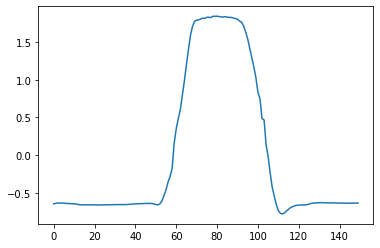

In [10]:
# plt.plot(X_train[0])


In [13]:
from lime_timeseries import LimeTimeSeriesExplainer
from lime import explanation
from lime import lime_base

In [52]:
def clf_predict(x=None, clf=clf):
  print('inside clf_predict')
  x = x.reshape(1,-1)
  y = clf.predict(x)
  return y

In [53]:
# explainer = LimeTimeSeriesExplainer(class_names=['gun', 'no-gun'])
# exp = explainer.explain_instance(series, clf_predict, num_features=num_features, num_samples=5000, num_slices=num_slices, replacement_method='total_mean')
# exp.as_pyplot_figure()

In [106]:
# x = np.mean(np.array([2]*10))
# print(type(x))
float(true_class[0])

2.0

In [260]:
class_flips = []
for ix in tqdm(range(len(X_test))):
  idx = ix # explained instance
  num_features = 10 # how many feature contained in explanation
  num_slices = 10 # split time series
  series = X_test[idx, :]
  window = len(series)/num_slices
  vseries = np.array([series]*num_slices)
  true_class = float(clf.predict(series.reshape(1,-1))[0])
  naive_mean = np.mean(series)
  perturbed_class = []
  
  for k in range(num_slices):
    #print(f'Start {k*window} to End {(k+1)*window}')
    start = int(k*window)
    end = int((k+1)*window)
    # print(f"Start {start} to End {end} has array length:{len(series[start:end])}")
    #naive mean for entire series
    vseries[k,start:end] = naive_mean
    class_ = clf.predict(vseries[k].reshape(1,-1))
    
    #check for class mismatch
    if class_[0]!=true_class:
      class_flips.append( [ix, naive_mean, start, end, int(true_class), class_[0]] ) 
    
    
  #   perturbed_class.append(class_[0])
  # perturbed_class = np.array(perturbed_class)
  # if np.mean(perturbed_class)!=true_class:
  #   class_equal.append(False)
  # else:
  #   class_equal.append(True)
# fig, ax = plt.subplots(num_slices+1,1, sharex=True)
# fig.set_figheight(22)
# fig.set_figwidth(8)
# ax[0].plot(series, label=f'Original Series (class: {true_class})')
# ax[0].legend(loc='upper right')
# for i in range(num_slices):
#   ax[i+1].plot(vseries[i], label=f"Series perturbed at slice: {i+1} (cls: {perturbed_class[i]})")
#   ax[i+1].legend(loc='upper right')
# plt.show()


100%|██████████| 150/150 [00:04<00:00, 33.47it/s]


In [261]:
df_class = pd.DataFrame(class_flips, columns=['test_sample','naive_mean', 'start', 'end','true_class','flipped_class'])

In [262]:
df_class.head()

,test_sample,naive_mean,start,end,true_class,flipped_class
0,0,-2.800000e-10,120,135,1,2
1,3,-1.020000e-09,120,135,1,2
2,3,-1.020000e-09,135,150,1,2
3,4,1.348667e-09,15,30,1,2
4,4,1.348667e-09,60,75,1,2


In [263]:
df_flip12 = df_class[(df_class['true_class']==1)&(df_class['flipped_class']==2)].copy().reset_index(drop=True)
df_flip21 = df_class[(df_class['true_class']==2)&(df_class['flipped_class']==1)].copy().reset_index(drop=True)

In [264]:
df_flip12['start'].value_counts()[
    df_flip12['start'].value_counts()>df_flip12['start'].value_counts().median()
    ]

120    59
15     39
60     34
30     32
105    31
Name: start, dtype: int64

In [265]:
mean_class_1 = np.mean(X_test[(y_test==1),:], axis=0)

In [266]:
flip12_instances = df_flip12['test_sample'].unique()
flip21_instances = df_flip21['test_sample'].unique()

print(len(flip12_instances))

70


In [267]:
flip12_instances[15]

29

Shape of df (9, 6)


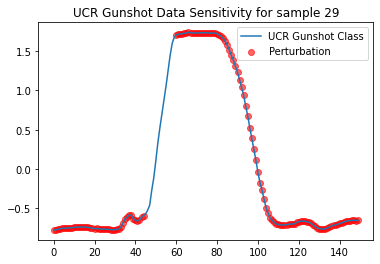

In [276]:
temp_instance_id = flip12_instances[15]
df_temp = df_flip12[(df_flip12['test_sample']==temp_instance_id)].reset_index(drop=True)
temp_index = df_temp[['start', 'end']].values
print(f"Shape of df {df_temp.shape}")

series = X_test[temp_instance_id]
perturb_series = np.array([-999.0]*len(series))
for idx in temp_index:
  perturb_series[idx[0]:idx[1]] = series[idx[0]:idx[1]]

perturb_index = np.arange(len(perturb_series))

perturb_vals = perturb_series[(perturb_series!=-999.0)]
perturb_index = perturb_index[(perturb_series!=-999.0)]

plt.plot(series, label='UCR Gunshot Class')
plt.scatter(perturb_index,perturb_vals, color='red', label='Perturbation', alpha=0.6)
plt.legend(loc='upper right')
plt.title(f'UCR Gunshot Data Sensitivity for sample {temp_instance_id}')
plt.show()

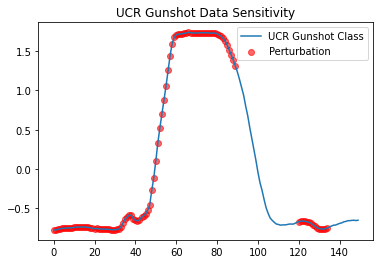

In [127]:
# len(class_flips)

245

In [128]:
X_test.shape

(150, 150)

In [124]:
instance_num, mu,  window_start, window_end, cls_true, cls_false = class_flips[0]

In [130]:
temps_x = X_test[instance_num, :].copy()
temps_x_perturbed = temps_x.copy()

In [131]:
temps_x_perturbed[window_start:window_end] = mu

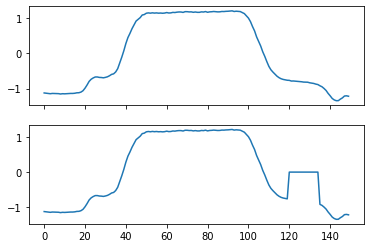

In [134]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(temps_x)
ax[1].plot(temps_x_perturbed)

In [135]:
class_flips

[(0, -2.800000142855197e-10, 120, 135, 1.0, 2),
 (3, -1.0200000133409048e-09, 120, 135, 1.0, 2),
 (3, -1.0200000133409048e-09, 135, 150, 1.0, 2),
 (4, 1.3486666820365182e-09, 15, 30, 1.0, 2),
 (4, 1.3486666820365182e-09, 60, 75, 1.0, 2),
 (4, 1.3486666820365182e-09, 105, 120, 1.0, 2),
 (4, 1.3486666820365182e-09, 120, 135, 1.0, 2),
 (6, 8.999999797273024e-10, 0, 15, 1.0, 2),
 (6, 8.999999797273024e-10, 15, 30, 1.0, 2),
 (6, 8.999999797273024e-10, 30, 45, 1.0, 2),
 (6, 8.999999797273024e-10, 45, 60, 1.0, 2),
 (6, 8.999999797273024e-10, 60, 75, 1.0, 2),
 (6, 8.999999797273024e-10, 75, 90, 1.0, 2),
 (6, 8.999999797273024e-10, 90, 105, 1.0, 2),
 (9, -4.5333333531516475e-10, 30, 45, 1.0, 2),
 (9, -4.5333333531516475e-10, 60, 75, 1.0, 2),
 (9, -4.5333333531516475e-10, 105, 120, 1.0, 2),
 (9, -4.5333333531516475e-10, 120, 135, 1.0, 2),
 (10, -1.1120000446377768e-09, 0, 15, 1.0, 2),
 (10, -1.1120000446377768e-09, 15, 30, 1.0, 2),
 (10, -1.1120000446377768e-09, 30, 45, 1.0, 2),
 (10, -1.1120000